In [3]:
# forecast_predictor.py
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from datetime import datetime
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 이 코드는 자체적으로 나눈 train/val/test set에 대한 실험용 앙상블 코드입니다!!!!! 최종 검증용이 아님에 유의하십시오.

In [4]:
# xgboost 단일 모델 예측 결과 csv 파일의 경로
xgb_pred = pd.read_csv('./obs_preds_xgboost_test_march.csv')
# forecastMLP 단일 모델 예측 결과 csv 파일의 경로
mlp_pred = pd.read_csv('./forecast_march_full.csv')
obs = pd.read_csv('./데이터_분석과제_7_기상관측데이터_2401_2503.csv')

# 앙상블 실행

In [5]:

def compute_saerror(true_df, pred_df, verbose=False):
    # 개별 MAE
    mae_temp = mean_absolute_error(true_df["temp"], pred_df["temp"])
    mae_hum = mean_absolute_error(true_df["humidity"], pred_df["humidity"])
    mae_pres = mean_absolute_error(true_df["pressure"], pred_df["pressure"])

    # 개별 RMSE
    mse_temp = mean_squared_error(true_df["temp"], pred_df["temp"])
    mse_hum = mean_squared_error(true_df["humidity"], pred_df["humidity"])
    mse_pres = mean_squared_error(true_df["pressure"], pred_df["pressure"])

    rmse_temp = np.sqrt(mse_temp)
    rmse_hum = np.sqrt(mse_hum)
    rmse_pres = np.sqrt(mse_pres)

    # 개별 SAError (변수별)
    sa_temp = 0.5 * (mae_temp + rmse_temp)
    sa_hum = 0.5 * (mae_hum + rmse_hum)
    sa_pres = 0.5 * (mae_pres + rmse_pres)

    # 전체 weighted SAError
    sa_weighted = 0.5 * sa_temp + 0.3 * sa_hum + 0.2 * sa_pres

    if verbose:
        print(f"  - temp   SAError (0.5): {sa_temp:.4f}")
        print(f"  - humidity SAError (0.3): {sa_hum:.4f}")
        print(f"  - pressure SAError (0.2): {sa_pres:.4f}")
        print(f"  → Weighted Total SAError: {sa_weighted:.4f}")

    return sa_weighted, (sa_temp, sa_hum, sa_pres)


In [6]:
def find_best_ensemble_ratio_with_plot(mlp_df, xgb_df, true_df):
    best_score = float("inf")
    best_temp = float("inf")
    best_humidity = float("inf")
    best_pressure = float("inf")

    best_ratio = None
    best_ratio_temp = None
    best_ratio_humidity = None
    best_ratio_pressure = None

    ratios = []
    sa_temp_list = []
    sa_hum_list = []
    sa_pres_list = []
    sa_total_list = []

    for i in range(0, 21):
        ratio_mlp = i * 0.05
        ratio_xgb = 1 - ratio_mlp

        ensemble_df = true_df.copy(deep=True)
        ensemble_df['temp'] = mlp_df['temp'] * ratio_mlp + xgb_df['temp'] * ratio_xgb
        ensemble_df['humidity'] = mlp_df['humidity'] * ratio_mlp + xgb_df['humidity'] * ratio_xgb
        ensemble_df['pressure'] = mlp_df['pressure'] * ratio_mlp + xgb_df['pressure'] * ratio_xgb

        total_score, (sa_temp, sa_hum, sa_pres) = compute_saerror(true_df, ensemble_df)

        print(f"MLP {ratio_mlp:.2f} | XGB {ratio_xgb:.2f} | Total: {total_score:.4f} "
              f"(Temp: {sa_temp:.4f}, Hum: {sa_hum:.4f}, Pres: {sa_pres:.4f})")

        ratios.append(ratio_mlp)
        sa_temp_list.append(sa_temp)
        sa_hum_list.append(sa_hum)
        sa_pres_list.append(sa_pres)
        sa_total_list.append(total_score)

        if total_score < best_score:
            best_score = total_score
            best_ratio = (ratio_mlp, ratio_xgb)
        if sa_temp < best_temp:
            best_temp = sa_temp
            best_ratio_temp = (ratio_mlp, ratio_xgb)
        if sa_hum < best_humidity:
            best_humidity = sa_hum
            best_ratio_humidity = (ratio_mlp, ratio_xgb)
        if sa_pres < best_pressure:
            best_pressure = sa_pres
            best_ratio_pressure = (ratio_mlp, ratio_xgb)

    # 결과 출력
    print(f"\n✅ Best Ratio - MLP: {best_ratio[0]:.2f}, XGB: {best_ratio[1]:.2f}, Score: {best_score:.4f}")
    print(f"✅ Best Ratio_temp     : MLP {best_ratio_temp[0]:.2f} | XGB {best_ratio_temp[1]:.2f} | SAError: {best_temp:.4f}")
    print(f"✅ Best Ratio_humidity : MLP {best_ratio_humidity[0]:.2f} | XGB {best_ratio_humidity[1]:.2f} | SAError: {best_humidity:.4f}")
    print(f"✅ Best Ratio_pressure : MLP {best_ratio_pressure[0]:.2f} | XGB {best_ratio_pressure[1]:.2f} | SAError: {best_pressure:.4f}")
    print(f"✅ Weighted Score from best per-variable ratios: {(best_temp*0.5 + best_humidity*0.3 + best_pressure*0.2):.4f}")

    # 시각화 (subplot + 최적 비율 수직선 표시)
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))

    axs[0, 0].plot(ratios, sa_temp_list, marker='o', label='Temp SAError')
    axs[0, 0].axvline(best_ratio_temp[0], color='gray', linestyle='--', label=f'Best @ {best_ratio_temp[0]:.2f}')
    axs[0, 0].set_title("Temp SAError vs MLP Ratio")
    axs[0, 0].set_ylabel("SAError")
    axs[0, 0].grid(True)
    axs[0, 0].legend()

    axs[0, 1].plot(ratios, sa_hum_list, marker='o', label='Humidity SAError', color='orange')
    axs[0, 1].axvline(best_ratio_humidity[0], color='gray', linestyle='--', label=f'Best @ {best_ratio_humidity[0]:.2f}')
    axs[0, 1].set_title("Humidity SAError vs MLP Ratio")
    axs[0, 1].grid(True)
    axs[0, 1].legend()

    axs[1, 0].plot(ratios, sa_pres_list, marker='o', label='Pressure SAError', color='green')
    axs[1, 0].axvline(best_ratio_pressure[0], color='gray', linestyle='--', label=f'Best @ {best_ratio_pressure[0]:.2f}')
    axs[1, 0].set_title("Pressure SAError vs MLP Ratio")
    axs[1, 0].set_xlabel("MLP Ratio")
    axs[1, 0].set_ylabel("SAError")
    axs[1, 0].grid(True)
    axs[1, 0].legend()

    axs[1, 1].plot(ratios, sa_total_list, marker='o', label='Total Weighted SAError', color='red', linestyle='--')
    axs[1, 1].axvline(best_ratio[0], color='gray', linestyle='--', label=f'Best @ {best_ratio[0]:.2f}')
    axs[1, 1].set_title("Total Weighted SAError vs MLP Ratio")
    axs[1, 1].set_xlabel("MLP Ratio")
    axs[1, 1].grid(True)
    axs[1, 1].legend()

    plt.suptitle("SAError vs MLP Ratio by Variable", fontsize=14)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    return best_ratio, best_score


In [7]:
def find_best_ensemble_ratio(mlp_df, xgb_df, true_df):
    best_score = float("inf")
    best_temp = float("inf")
    best_humidity = float("inf")
    best_pressure = float("inf")

    best_ratio = None
    best_ratio_temp = None
    best_ratio_humidity = None
    best_ratio_pressure = None

    for i in range(0, 21):
        ratio_mlp = i * 0.05
        ratio_xgb = 1 - ratio_mlp

        ensemble_df = true_df.copy(deep=True)
        ensemble_df['temp'] = mlp_df['temp'] * ratio_mlp + xgb_df['temp'] * ratio_xgb
        ensemble_df['humidity'] = mlp_df['humidity'] * ratio_mlp + xgb_df['humidity'] * ratio_xgb
        ensemble_df['pressure'] = mlp_df['pressure'] * ratio_mlp + xgb_df['pressure'] * ratio_xgb

        total_score, (sa_temp, sa_hum, sa_pres) = compute_saerror(true_df, ensemble_df)

        print(f"MLP {ratio_mlp:.2f} | XGB {ratio_xgb:.2f} | Total: {total_score:.4f} "
              f"(Temp: {sa_temp:.4f}, Hum: {sa_hum:.4f}, Pres: {sa_pres:.4f})")

        if total_score < best_score:
            best_score = total_score
            best_ratio = (ratio_mlp, ratio_xgb)
        if sa_temp < best_temp:
            best_temp = sa_temp
            best_ratio_temp = (ratio_mlp, ratio_xgb)
        if sa_hum < best_humidity:
            best_humidity = sa_hum
            best_ratio_humidity = (ratio_mlp, ratio_xgb)
        if sa_pres < best_pressure:
            best_pressure = sa_pres
            best_ratio_pressure = (ratio_mlp, ratio_xgb)

    print(f"\n✅ Best Ratio - MLP: {best_ratio[0]:.2f}, XGB: {best_ratio[1]:.2f}, Score: {best_score:.4f}")

    print(f"\n✅ Best Ratio_temp - MLP: {best_ratio_temp[0]:.2f}, XGB: {best_ratio_temp[1]:.2f}, Score: {best_temp:.4f}")
    print(f"\n✅ Best Ratio_humidity - MLP: {best_ratio_humidity[0]:.2f}, XGB: {best_ratio_humidity[1]:.2f}, Score: {best_humidity:.4f}")
    print(f"\n✅ Best Ratio_pressure - MLP: {best_ratio_pressure[0]:.2f}, XGB: {best_ratio_pressure[1]:.2f}, Score: {best_pressure:.4f}")
    print(f"\n✅ Best Ratio - Score: {(best_temp*0.5+best_humidity*0.3+best_pressure*0.2):.4f}")



In [8]:
obs.columns = ['datetime','humidity','temp','pressure']
obs["datetime"] = pd.to_datetime(obs["datetime"])
mask = (obs["datetime"] >= "2025-03-01") & (obs["datetime"] < "2025-04-01")
obs = obs.loc[mask].reset_index(drop=True)
obs

,datetime,humidity,temp,pressure
0,2025-03-01 00:00:00,77.53,4.49,760.18789
1,2025-03-01 01:00:00,78.83,3.65,760.27499
2,2025-03-01 02:00:00,81.44,2.96,760.27813
3,2025-03-01 03:00:00,82.18,2.28,760.14989
4,2025-03-01 04:00:00,87.67,1.64,760.01172
...,...,...,...,...
739,2025-03-31 19:00:00,34.78,11.20,762.24051
740,2025-03-31 20:00:00,38.48,9.89,762.69059
741,2025-03-31 21:00:00,44.51,8.76,763.16659
742,2025-03-31 22:00:00,51.41,7.92,763.54106


In [9]:
mlp_pred['pressure'] = mlp_pred['pressure']
mlp_pred

,datetime,humidity,temp,pressure
0,2025-03-01 00:00:00,71.042885,5.454025,761.22730
1,2025-03-01 01:00:00,73.311780,4.416752,760.88570
2,2025-03-01 02:00:00,75.796875,4.271547,760.98610
3,2025-03-01 03:00:00,77.861850,4.257541,760.84100
4,2025-03-01 04:00:00,80.349130,4.044000,760.65190
...,...,...,...,...
715,2025-03-31 19:00:00,39.404860,10.641838,762.62320
716,2025-03-31 20:00:00,48.503307,9.386549,763.14325
717,2025-03-31 21:00:00,54.569600,7.704299,763.50090
718,2025-03-31 22:00:00,59.318620,6.685977,763.59120


In [10]:
xgb_pred['pressure'] = xgb_pred['pressure']
xgb_pred

,datetime,temp,humidity,pressure
0,2025-03-01 00:00:00,5.450134,74.868457,761.585432
1,2025-03-01 01:00:00,3.735987,74.930457,761.141548
2,2025-03-01 02:00:00,3.745935,75.971640,761.160597
3,2025-03-01 03:00:00,3.700508,77.188089,760.979600
4,2025-03-01 04:00:00,3.591356,78.889708,760.805471
...,...,...,...,...
715,2025-03-31 19:00:00,11.919143,45.095097,762.584266
716,2025-03-31 20:00:00,10.465229,52.866091,763.110120
717,2025-03-31 21:00:00,8.968131,58.008117,763.383403
718,2025-03-31 22:00:00,8.234213,61.350990,763.448824


In [11]:
mlp_pred["datetime"] = pd.to_datetime(mlp_pred["datetime"])
obs["datetime"] = pd.to_datetime(obs["datetime"])

# 공통 datetime만 남기기
obs_matched = obs[obs["datetime"].isin(mlp_pred["datetime"])].reset_index(drop=True)

MLP 0.00 | XGB 1.00 | Total: 3.5945 (Temp: 1.4071, Hum: 9.2750, Pres: 0.5423)
MLP 0.05 | XGB 0.95 | Total: 3.5810 (Temp: 1.3984, Hum: 9.2477, Pres: 0.5373)
MLP 0.10 | XGB 0.90 | Total: 3.5685 (Temp: 1.3903, Hum: 9.2226, Pres: 0.5330)
MLP 0.15 | XGB 0.85 | Total: 3.5574 (Temp: 1.3832, Hum: 9.2000, Pres: 0.5292)
MLP 0.20 | XGB 0.80 | Total: 3.5477 (Temp: 1.3772, Hum: 9.1796, Pres: 0.5260)
MLP 0.25 | XGB 0.75 | Total: 3.5394 (Temp: 1.3723, Hum: 9.1619, Pres: 0.5234)
MLP 0.30 | XGB 0.70 | Total: 3.5323 (Temp: 1.3683, Hum: 9.1462, Pres: 0.5215)
MLP 0.35 | XGB 0.65 | Total: 3.5263 (Temp: 1.3651, Hum: 9.1325, Pres: 0.5201)
MLP 0.40 | XGB 0.60 | Total: 3.5218 (Temp: 1.3630, Hum: 9.1214, Pres: 0.5196)
MLP 0.45 | XGB 0.55 | Total: 3.5190 (Temp: 1.3622, Hum: 9.1130, Pres: 0.5198)
MLP 0.50 | XGB 0.50 | Total: 3.5174 (Temp: 1.3624, Hum: 9.1070, Pres: 0.5207)
MLP 0.55 | XGB 0.45 | Total: 3.5173 (Temp: 1.3637, Hum: 9.1035, Pres: 0.5222)
MLP 0.60 | XGB 0.40 | Total: 3.5189 (Temp: 1.3663, Hum: 9.1030, 

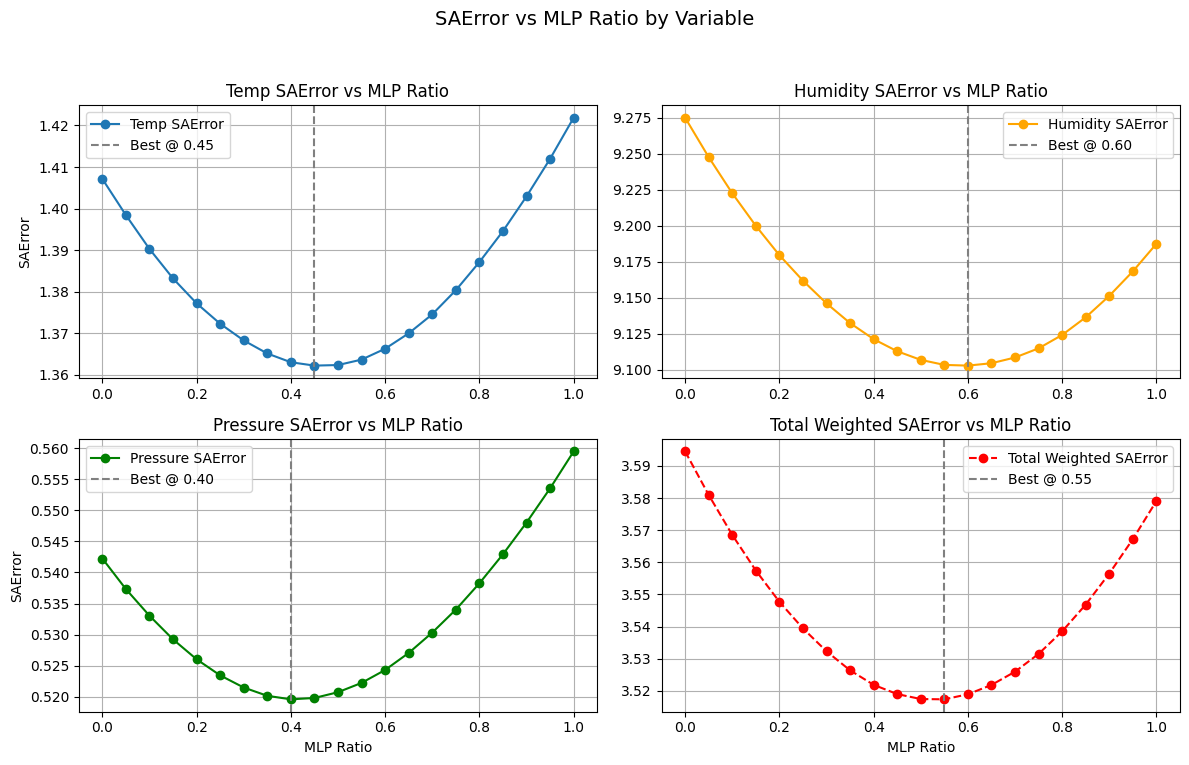

((0.55, 0.44999999999999996), 3.5173260337997743)

In [12]:
cols = ["temp", "humidity", "pressure"]

find_best_ensemble_ratio_with_plot(
    mlp_pred[cols].reset_index(drop=True),
    xgb_pred[cols].reset_index(drop=True),
    obs_matched[cols].reset_index(drop=True)
)